In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import utils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(128, 1, bias = False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1,128)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [4]:
def noise(net,coeff):
    _noise = 0
    for param in net.parameters():
        _noise += torch.sum(param*torch.randn_like(param.data)*coeff)
    return _noise

def reg(net1,net2,coeff):
    _reg = 0
    for param1,param2 in zip(net1.parameters(),net2.parameters()):
        sub = param1-param2.detach()
        _reg += torch.sum(sub*sub*coeff)
    return _reg

## 1. Generate the data

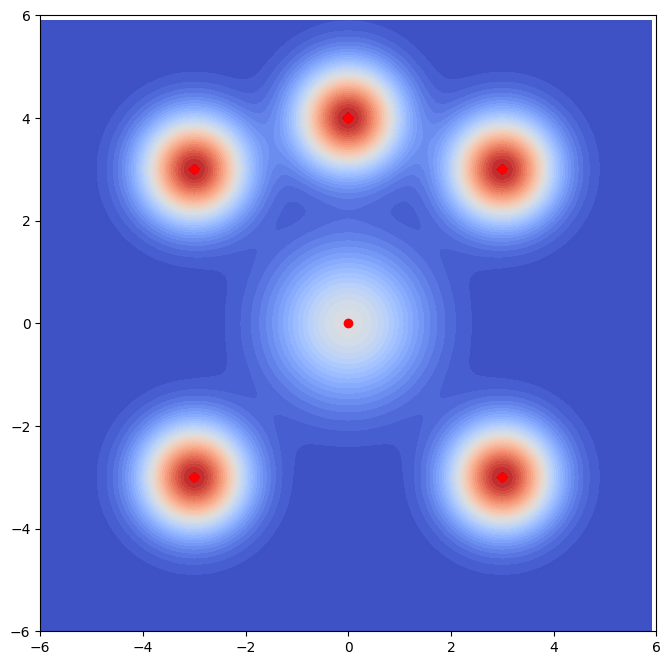

In [11]:
means = np.array([[0, 0], [3, 3], [-3, 3], [3, -3], [-3, -3], [0, 4]])
covs = [np.eye(2) * 0.5 for _ in range(6)]
covs[0] = np.eye(2) * 1
weights = np.ones(6) / 6

def gaussian_mixture(x, means, covs, weights):
    n = len(means)
    result = 0
    for i in range(n):
        diff = x - means[i]
        result += weights[i] * np.exp(-0.5 * diff.T @ np.linalg.inv(covs[i]) @ diff) / (2 * np.pi * np.sqrt(np.linalg.det(covs[i])))
    return result

# Plot the target distribution
x, y = np.mgrid[-6:6:.1, -6:6:.1]
pos = np.dstack((x, y))
z = np.apply_along_axis(lambda p: gaussian_mixture(p, means, covs, weights), 2, pos)

plt.figure(figsize=(8, 8))
plt.contourf(x, y, z, levels=50, cmap='coolwarm')
plt.scatter(*zip(*means), c='r')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [20]:
xy = np.stack((x, y), axis=-1)
data = np.concatenate( xy, axis=0)
z_ = np.concatenate( z, axis=0)
x_train, x_test, y_train, y_test = train_test_split(data, z_, test_size=0.2, random_state=42)

train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=64, shuffle=False)

model = Net()
model_anchor = Net()

model_anchor = utils.resample(model_anchor,model)
optimizer = optim.SGD(list(model.parameters()) + list(model_anchor.parameters()), lr=0.01, weight_decay=1e-5)


In [23]:
# Training
epochs = 100
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        y_pred_anchor = model_anchor(x_batch)
        loss = F.mse_loss(y_pred, y_batch) + noise(model,0.1) + reg(model,model_anchor,0.1)
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        model_anchor = utils.resample(model_anchor,model)
        print(f'Epoch {epoch}, Loss: {loss.item()}')

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float